In [548]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [549]:
filepath = 'US Wheat Futures Historical Data.csv'
raw_csv_data = filepath

# Read CSV file
df = pd.read_csv('US Wheat Futures Historical Data.csv')

# Show the first 5 row and last 5 row for check
print(df.head())
print(df.tail())


         Date   Price    Open    High     Low     Vol. Change %
0  01/01/2005  291.00  307.50  312.00  287.50  440.98K   -5.37%
1  01/03/2005  302.25  307.50  307.50  301.50   13.22K    3.87%
2  01/04/2005  296.00  301.75  302.00  292.25   43.29K   -2.07%
3  01/05/2005  299.75  295.75  301.00  295.25   18.07K    1.27%
4  01/06/2005  308.25  299.25  308.50  299.25   30.55K    2.84%
            Date   Price    Open    High     Low    Vol. Change %
4980  12/22/2023  616.25  612.50  618.25  610.75  26.13K    0.61%
4981  12/26/2023  636.25  615.00  639.75  611.50  40.67K    3.25%
4982  12/27/2023  623.00  636.00  637.50  619.25  38.06K   -2.08%
4983  12/28/2023  631.50  624.25  636.25  621.75  32.25K    1.36%
4984  12/29/2023  628.00  631.00  633.50  621.50  34.75K   -0.55%


In [550]:
# we are deleting the unnecessary columns 
df = df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

# checking 
print(df.head())


         Date   Price
0  01/01/2005  291.00
1  01/03/2005  302.25
2  01/04/2005  296.00
3  01/05/2005  299.75
4  01/06/2005  308.25


In [551]:
print(df.dtypes) # we are looking our columns' data types

Date     object
Price    object
dtype: object


In [552]:
# Virgülleri kaldırarak sayısal türe dönüştürme
df['Price'] = df['Price'].replace({',': ''}, regex=True)

# Sayısal verilere dönüştürme
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Tam sayıya dönüştürme
df['Price'] = df['Price'].astype(int)

# NaN değerleri kontrol etme (eğer varsa)
print(df['Price'].isna().sum())

print(df.dtypes) # we are looking our columns' data types

# Veriyi 'datetime' formatına çeviriyoruz
df['Date'] = pd.to_datetime(df['Date'])

print(df.dtypes) # checking the format

0
Date     object
Price     int64
dtype: object
Date     datetime64[ns]
Price             int64
dtype: object


In [553]:
#EKSİK TARİHLER VAR VE BU TARİHLERİ DOLDURACAĞIZ. HANGİ ŞEKİLDE DOLDURACAĞIMIZI SEÇİYORUZ , 
#BİRİNCİSİ LİNEER INTERPOLASYON
#İKİNCİSİ HAREKETLİ ORTALAMA OLACAK
#BUNLARI MAE,MSE,RMSE İLE DEĞERLENDİRİP HANGİSİNİN DAHA DOĞRU SONUÇ VERDİĞİNE BAKACAĞIZ VE İYİ SONUÇ VERENLE VERİLERİMİZİ DOLDURACAĞIZ.

In [554]:
# Tarih sütunu zaten datetime formatında ve Price int formatında
df = df.set_index("Date")  # Tarih sütununu indeks yap

# 1. Tüm tarih aralığını oluştur (günlük aralık)
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")

# 2. Eksik tarihleri ekle, mevcut fiyatları koru
df = df.reindex(full_range)

# 3. Eksik fiyatları doldur (örnek: lineer interpolasyon)
linearinterpolation = df['Price'].interpolate(method='linear')
print('Linear Interpolation Results : \n ' , linearinterpolation, '\n')

# 3. Eksik fiyatları doldur (Hareketli Ortalama)
movingaverage = df['Price'].fillna(df['Price'].rolling(window=3, min_periods=1).mean())
print('Moving Average Results : \n ' , movingaverage,'\n')
#Fakat burada NaN değerleri ile karşılaştık.

# Eksik değerleri bir önceki ve bir sonraki mevcut fiyatların ortalaması ile doldur
#2005-01-01	291
#2005-01-02	NaN  296.5 olacak
#2005-01-03	302
movingaveragerevised = df['Price'] = df['Price'].fillna((df['Price'].ffill() + df['Price'].bfill()) / 2)
print('Moving Average Revised Results : \n ' , movingaveragerevised,'\n')


Linear Interpolation Results : 
  2005-01-01    291.0
2005-01-02    296.5
2005-01-03    302.0
2005-01-04    296.0
2005-01-05    299.0
              ...  
2023-12-25    631.0
2023-12-26    636.0
2023-12-27    623.0
2023-12-28    631.0
2023-12-29    628.0
Freq: D, Name: Price, Length: 6937, dtype: float64 

Moving Average Results : 
  2005-01-01    291.0
2005-01-02    291.0
2005-01-03    302.0
2005-01-04    296.0
2005-01-05    299.0
              ...  
2023-12-25      NaN
2023-12-26    636.0
2023-12-27    623.0
2023-12-28    631.0
2023-12-29    628.0
Freq: D, Name: Price, Length: 6937, dtype: float64 

Moving Average Revised Results : 
  2005-01-01    291.0
2005-01-02    296.5
2005-01-03    302.0
2005-01-04    296.0
2005-01-05    299.0
              ...  
2023-12-25    626.0
2023-12-26    636.0
2023-12-27    623.0
2023-12-28    631.0
2023-12-29    628.0
Freq: D, Name: Price, Length: 6937, dtype: float64 



In [555]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Test için bazı gerçek değerleri çıkararak değerlendirme yapmak
test_df = df.copy()
known_values = test_df['Price'].dropna()  # Gerçek değerlere sahip olan satırlar
test_indices = known_values.sample(frac=0.1, random_state=42).index  # %10'luk rastgele veri çıkarılır
true_values = test_df.loc[test_indices, 'Price']  # Gerçek değerler
test_df.loc[test_indices, 'Price'] = np.nan  # Bu değerleri eksik yap

# 1. Lineer Interpolasyon ile doldurma
linear_interpolated = test_df['Price'].interpolate(method='linear')

# 2. Hareketli Ortalama ile doldurma
moving_average = test_df['Price'].fillna(test_df['Price'].rolling(window=3, min_periods=1).mean())

# 3. Önceki ve sonraki değerlerin ortalaması ile doldurma
moving_average_revised = test_df['Price'].fillna((test_df['Price'].ffill() + test_df['Price'].bfill()) / 2)

# Hata metriklerini hesaplama
def calculate_errors(true_values, predicted_values):
    # NaN'leri kaldırarak sadece geçerli (gerçek ve tahmin edilen) değerlerle hesaplama yapalım
    mask = true_values.notna() & predicted_values.notna()
    true_values_filtered = true_values[mask]
    predicted_values_filtered = predicted_values[mask]
    
    mae = mean_absolute_error(true_values_filtered, predicted_values_filtered)
    mse = mean_squared_error(true_values_filtered, predicted_values_filtered)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Her yöntemin hata metriklerini hesapla
results = {}
results['Linear Interpolation'] = calculate_errors(
    true_values, linear_interpolated.loc[test_indices])
results['Moving Average'] = calculate_errors(
    true_values, moving_average.loc[test_indices])
results['Moving Average Revised'] = calculate_errors(
    true_values, moving_average_revised.loc[test_indices])

# Sonuçları yazdırma
for method, (mae, mse, rmse) in results.items():
    print(f"{method}:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}\n")


Linear Interpolation:
  MAE: 5.201488952929875
  MSE: 68.45383545469102
  RMSE: 8.273683306405378

Moving Average:
  MAE: 7.997822931785196
  MSE: 167.91418722786648
  RMSE: 12.958170674438058

Moving Average Revised:
  MAE: 5.22514409221902
  MSE: 67.26035662824208
  RMSE: 8.201241163887456



In [556]:
# Son olarak df'yi lineer interpolasyon sonuçlarıyla güncelle
df['Price'] = linearinterpolation
print('Final Dataframe with Linear Interpolation: \n', df)

Final Dataframe with Linear Interpolation: 
             Price
2005-01-01  291.0
2005-01-02  296.5
2005-01-03  302.0
2005-01-04  296.0
2005-01-05  299.0
...           ...
2023-12-25  631.0
2023-12-26  636.0
2023-12-27  623.0
2023-12-28  631.0
2023-12-29  628.0

[6937 rows x 1 columns]


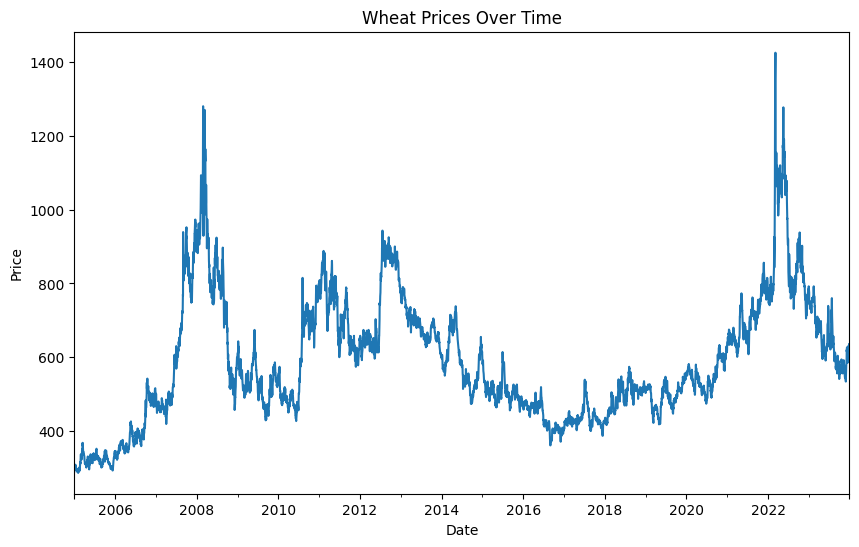

In [557]:
import matplotlib.pyplot as plt

# Veriyi görselleştirme
df['Price'].plot(figsize=(10,6))
plt.title('Wheat Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [558]:
#FORECAST FOR THE NEXT 5 YEARS


Value at Risk (VaR) at 95% confidence level: -0.10636049925567195


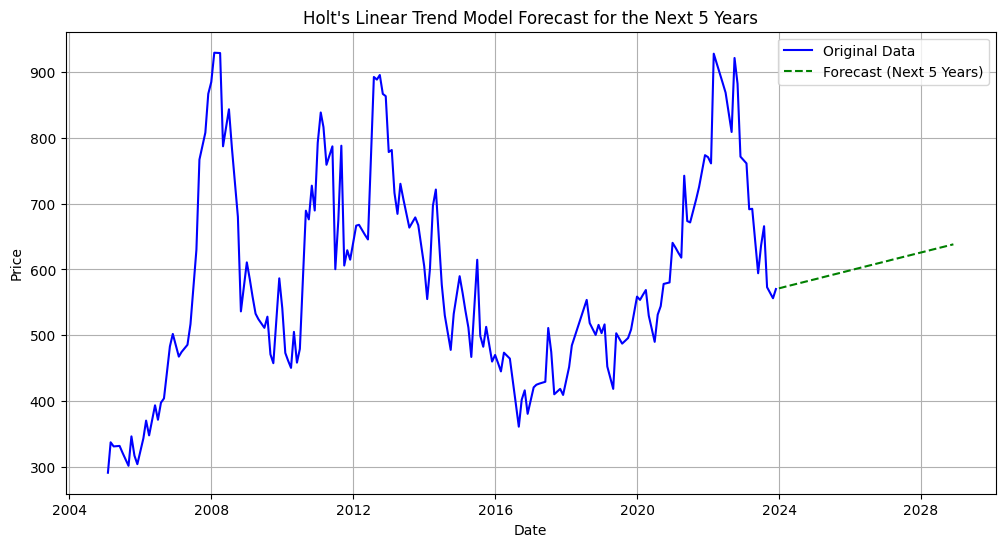

In [559]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Load and preprocess the dataset
raw_csv_data = filepath  # Replace with your actual file path
df = pd.read_csv(raw_csv_data)

# Ensure 'Date' column exists and is converted to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure 'Price' column is numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(subset=['Price'], inplace=True)  # Remove rows with missing 'Price' values

# Ensure the index has a frequency
df = df.asfreq('ME')

# Handle missing data
df['Price'] = df['Price'].interpolate(method='linear')  # Interpolate missing values

# Fit the Holt's Linear Trend Model (Double Exponential Smoothing)
des_model = ExponentialSmoothing(df['Price'], trend='add', seasonal=None).fit(optimized=True)

# Forecast the next 5 years (60 months)
forecast_steps = 60
forecast = des_model.forecast(steps=forecast_steps)

# Create a DatetimeIndex for forecast 
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='ME')[1:]

# Create a forecast Series with the new index
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Calculate daily returns
returns = df['Price'].pct_change().dropna()

# Calculate the 5% quantile (VaR at 95% confidence level)
var_95 = np.percentile(returns, 5)

# Print forecasted values and VaR
#print("Forecasted Values for the Next 5 Years:")
#print(forecast_series)
print(f"\nValue at Risk (VaR) at 95% confidence level: {var_95}")

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label="Original Data", color="blue")
plt.plot(forecast_series, label="Forecast (Next 5 Years)", color='green', linestyle='--')
plt.legend()
plt.title("Holt's Linear Trend Model Forecast for the Next 5 Years")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [560]:
#SIMPLE EXPONENTIAL SMOOTHING


Value at Risk (VaR) at 95% confidence level: -0.09271336571623623


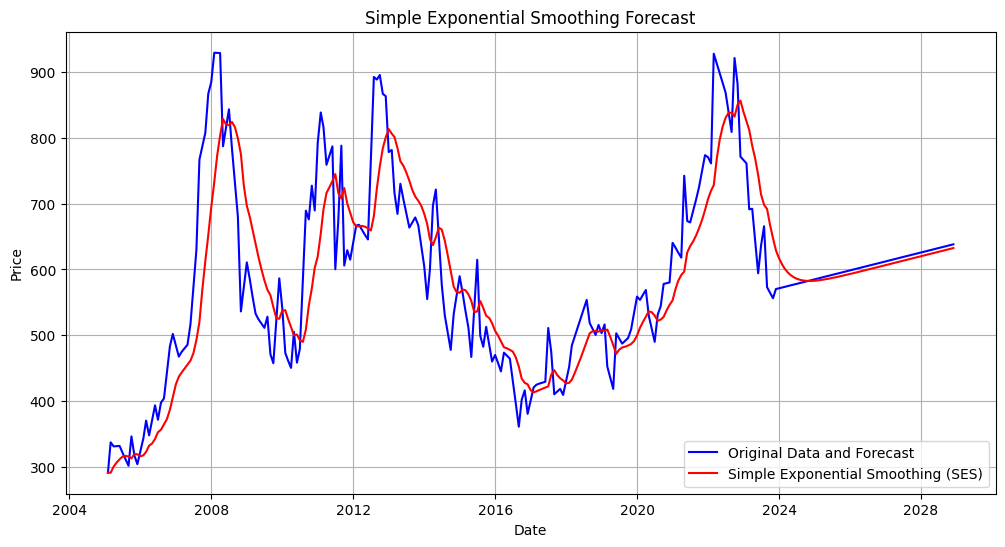

In [561]:
# ... (rest of the code remains the same)

# Create a forecast Series with the new index
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Combine the original data and forecast
combined_data = pd.concat([df['Price'], forecast_series])

# Calculate daily returns
returns = combined_data.pct_change().dropna()

# Calculate the 5% quantile (VaR at 95% confidence level)
var_95 = np.percentile(returns, 5)

# Print forecasted values and VaR
#print("Forecasted Values for the Next 5 Years:")
#print(forecast_series)
print(f"\nValue at Risk (VaR) at 95% confidence level: {var_95}")

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label="Original Data and Forecast", color="blue")

# Add Simple Exponential Smoothing (SES) model
ses_model = SimpleExpSmoothing(combined_data).fit(smoothing_level=0.2, optimized=False)
ses_fitted = ses_model.fittedvalues

# Plot SES model
plt.plot(ses_fitted, label="Simple Exponential Smoothing (SES)", color="red")

plt.legend()
plt.title("Simple Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [562]:
#DOUBLE EXPONENTIAL SMOOTHING


Value at Risk (VaR) at 95% confidence level: -0.09271336571623623


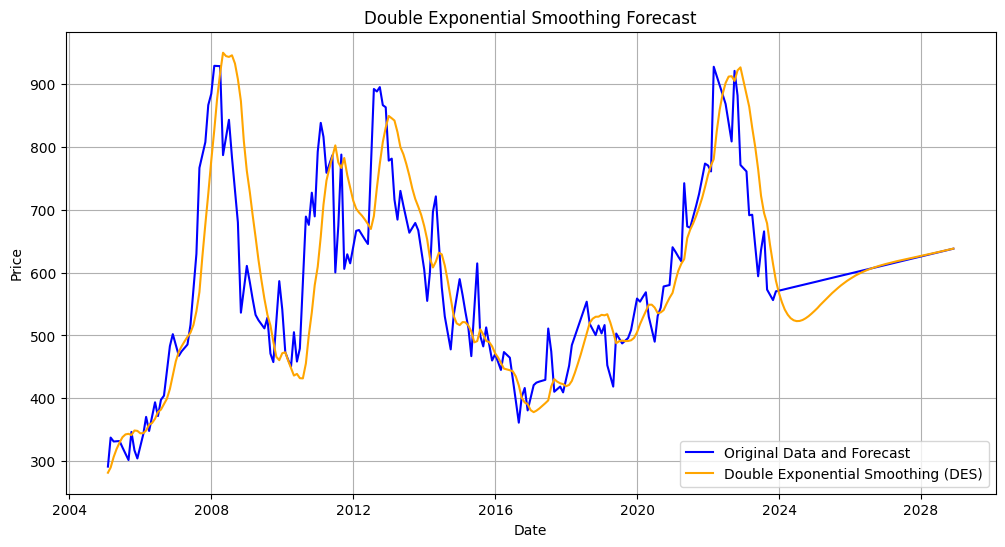

In [563]:
# ... (rest of the code remains the same)

# Create a forecast Series with the new index
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Combine the original data and forecast
combined_data = pd.concat([df['Price'], forecast_series])

# Calculate daily returns
returns = combined_data.pct_change().dropna()

# Calculate the 5% quantile (VaR at 95% confidence level)
var_95 = np.percentile(returns, 5)

# Print forecasted values and VaR
#print("Forecasted Values for the Next 5 Years:")
#print(forecast_series)
print(f"\nValue at Risk (VaR) at 95% confidence level: {var_95}")

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label="Original Data and Forecast", color="blue")

# Add Double Exponential Smoothing (DES) model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
des_model = ExponentialSmoothing(combined_data, trend='add', seasonal=None).fit(smoothing_level=0.2, smoothing_trend=0.1)
des_fitted = des_model.fittedvalues

# Plot DES model
plt.plot(des_fitted, label="Double Exponential Smoothing (DES)", color="orange")

plt.legend()
plt.title("Double Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [564]:
#TRIPLE EXPONENTIAL SMOOTHING


Value at Risk (VaR) at 95% confidence level: -0.09271336571623623


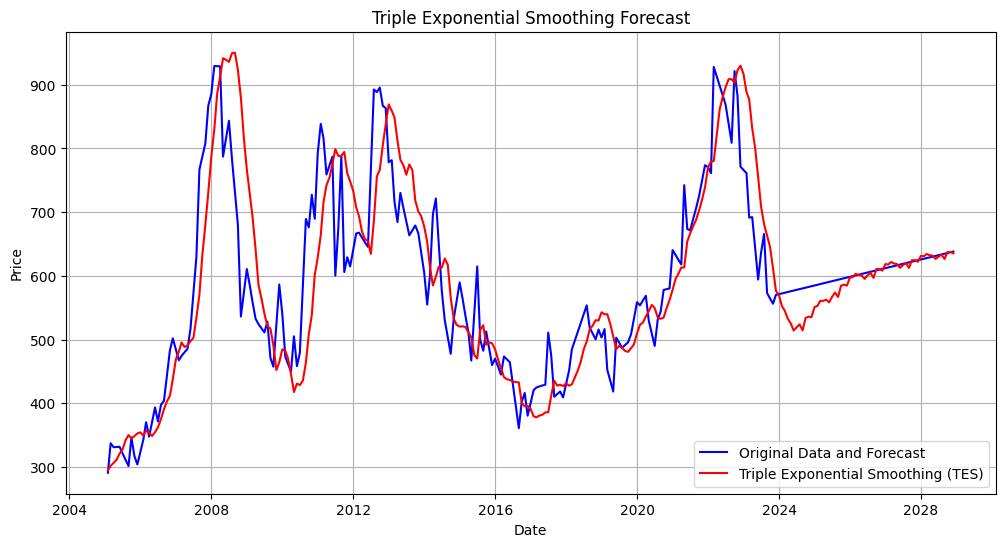

In [565]:
# ... (rest of the code remains the same)

# Create a forecast Series with the new index
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Combine the original data and forecast
combined_data = pd.concat([df['Price'], forecast_series])

# Calculate daily returns
returns = combined_data.pct_change().dropna()

# Calculate the 5% quantile (VaR at 95% confidence level)
var_95 = np.percentile(returns, 5)

# Print forecasted values and VaR
#print("Forecasted Values for the Next 5 Years:")
#print(forecast_series)
print(f"\nValue at Risk (VaR) at 95% confidence level: {var_95}")

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label="Original Data and Forecast", color="blue")

# Add Triple Exponential Smoothing (TES) model
tes_model = ExponentialSmoothing(combined_data, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.2, smoothing_trend=0.1, smoothing_seasonal=0.1)
tes_fitted = tes_model.fittedvalues

# Plot TES model
plt.plot(tes_fitted, label="Triple Exponential Smoothing (TES)", color="red")

plt.legend()
plt.title("Triple Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [566]:
#ALL IN ONE


Value at Risk (VaR) at 95% confidence level: -0.09271336571623623


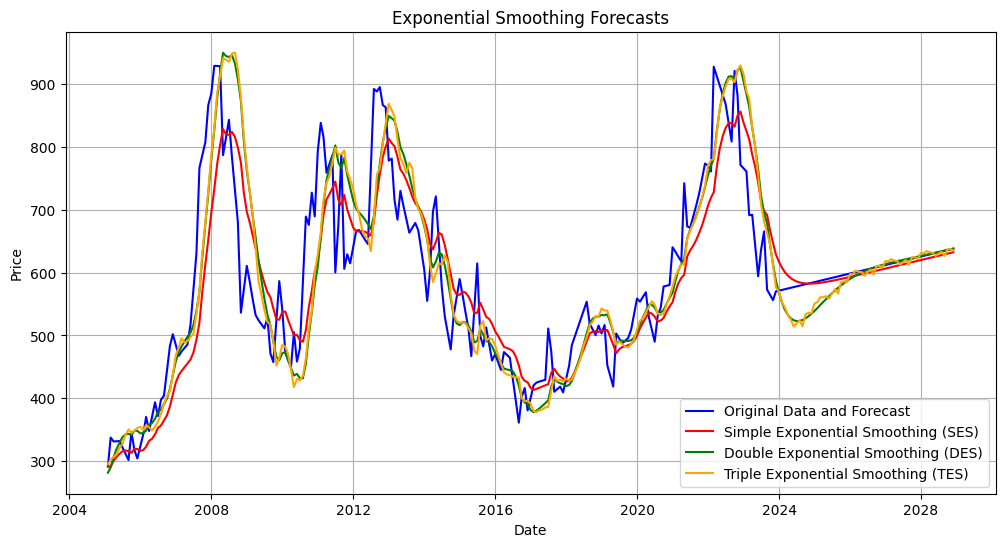

In [567]:
# ... (rest of the code remains the same)

# Create a forecast Series with the new index
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Combine the original data and forecast
combined_data = pd.concat([df['Price'], forecast_series])

# Calculate daily returns
returns = combined_data.pct_change().dropna()

# Calculate the 5% quantile (VaR at 95% confidence level)
var_95 = np.percentile(returns, 5)

# Print forecasted values and VaR
#print("Forecasted Values for the Next 5 Years:")
#print(forecast_series)
print(f"\nValue at Risk (VaR) at 95% confidence level: {var_95}")

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label="Original Data and Forecast", color="blue")

# Add Simple Exponential Smoothing (SES) model
ses_model = SimpleExpSmoothing(combined_data).fit(smoothing_level=0.2, optimized=False)
ses_fitted = ses_model.fittedvalues

# Plot SES model
plt.plot(ses_fitted, label="Simple Exponential Smoothing (SES)", color="red")

# Add Double Exponential Smoothing (DES) model
des_model = ExponentialSmoothing(combined_data, trend='add', seasonal=None).fit(smoothing_level=0.2, smoothing_trend=0.1)
des_fitted = des_model.fittedvalues

# Plot DES model
plt.plot(des_fitted, label="Double Exponential Smoothing (DES)", color="green")

# Add Triple Exponential Smoothing (TES) model
tes_model = ExponentialSmoothing(combined_data, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.2, smoothing_trend=0.1, smoothing_seasonal=0.1)
tes_fitted = tes_model.fittedvalues

# Plot TES model
plt.plot(tes_fitted, label="Triple Exponential Smoothing (TES)", color="orange")

plt.legend()
plt.title("Exponential Smoothing Forecasts")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [568]:
#VAR (Vector Autoregression) 

In [569]:
# ... (rest of the code remains the same)

# Import necessary libraries
from statsmodels.tsa.api import VAR

# Create a DataFrame with at least two columns for VAR
combined_data_df = pd.DataFrame({'Price': combined_data, 'Price_Lagged': combined_data.shift(1)}).dropna()
ses_fitted_df = pd.DataFrame({'SES_Fitted': ses_fitted, 'SES_Fitted_Lagged': ses_fitted.shift(1)}).dropna()
des_fitted_df = pd.DataFrame({'DES_Fitted': des_fitted, 'DES_Fitted_Lagged': des_fitted.shift(1)}).dropna()
tes_fitted_df = pd.DataFrame({'TES_Fitted': tes_fitted, 'TES_Fitted_Lagged': tes_fitted.shift(1)}).dropna()

# Calculate VAR for original data and forecast
var_original = VAR(combined_data_df).fit()
print(f"\nVAR for Original Data and Forecast: {var_original.params}")

# Calculate VAR for SES model
var_ses = VAR(ses_fitted_df).fit()
print(f"\nVAR for Simple Exponential Smoothing (SES): {var_ses.params}")

# Calculate VAR for DES model
var_des = VAR(des_fitted_df).fit()
print(f"\nVAR for Double Exponential Smoothing (DES): {var_des.params}")

# Calculate VAR for TES model
var_tes = VAR(tes_fitted_df).fit()
print(f"\nVAR for Triple Exponential Smoothing (TES): {var_tes.params}")

#SUMMARY
print(var_original.summary())
print(var_ses.summary())
print(var_des.summary())
print(var_tes.summary())


VAR for Original Data and Forecast:                      Price  Price_Lagged
const            33.631498  6.473661e-13
L1.Price          1.000362  1.000000e+00
L1.Price_Lagged  -0.055732 -2.220446e-16

VAR for Simple Exponential Smoothing (SES):                       SES_Fitted  SES_Fitted_Lagged
const                   7.728277       3.874271e-13
L1.SES_Fitted           1.783485       1.000000e+00
L1.SES_Fitted_Lagged   -0.796304       0.000000e+00

VAR for Double Exponential Smoothing (DES):                       DES_Fitted  DES_Fitted_Lagged
const                   8.796639       4.806660e-13
L1.DES_Fitted           1.843150       1.000000e+00
L1.DES_Fitted_Lagged   -0.857790      -2.220446e-16

VAR for Triple Exponential Smoothing (TES):                       TES_Fitted  TES_Fitted_Lagged
const                  11.012862       1.514642e-14
L1.TES_Fitted           1.668457       1.000000e+00
L1.TES_Fitted_Lagged   -0.686526      -3.330669e-16
  Summary of Regression Results   
Model

C:\Users\MDKni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\vector_ar\var_model.py:2493: RuntimeWarning: invalid value encountered in divide
  return acovs / np.outer(sd, sd)
